# Tunable Scrambling Circuit

Reference: Verified Quantum Information Scrambling https://arxiv.org/abs/1806.02807

![paper](./pics/Telpo1_Tunable_Scrambling_Circ.jpg)

![experiment](./pics/Telpo2_Tunable_Scrambling_Circ.jpg)

Tunable Circ:

![tunable](./pics/Telpo3_Tunable_Scrambling_Circ.jpg)

From Scrambling Library
![tunablegrover](./pics/Tunable_Scrambling_Grover_Circ.jpg)

# Implementation

To make this protocol more hardware efficient, we adapted the method depicted above. Instead of XX Gates, we are using CZ gates as entangling gates. The alpha parameter to tune the scrambling now can be chosen between -1 for no scrambling or zero percent teleportation fidelity, and +1 for full scrambling and teleporation fidelity. When alpha is set to zero, a 50% fidelity is expected.

In [1]:
# general imports:
%matplotlib inline
import matplotlib, qiskit, pprint, itertools
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.circuit import *
from qiskit.circuit.library.standard_gates import *
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMelbourne
from qiskit.visualization import *
from qiskit.circuit.library import *

In [2]:
# import utils for Quantum Information Scrambling Verification Test:
from QSVT_utils import *

In [3]:
# load account:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# get simulators:
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mel = FakeMelbourne() # simulator f_mel for simulator backend mel
qasm_simulator = Aer.get_backend('qasm_simulator') 

In [4]:
#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits scrambling unitary operates on
n = 3

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# get pairs for two-qubit gates in scrambling protocol
upper_pairs, lower_pairs = get_unitary_pairs(qnum)

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

# Experiment A: alpha = +1


 Fidelity Bob Qubit:   	 100.0%


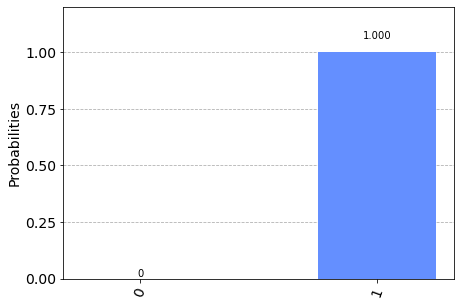

In [5]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

alpha = 1

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)


circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

#circ.draw('mpl') # see circ

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment B: alpha = -1


 Fidelity Bob Qubit:   	 0.0%


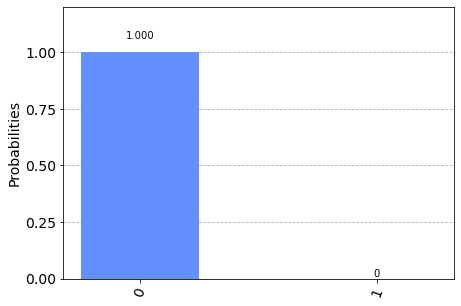

In [6]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

alpha = -1

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)


circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

#circ.draw('mpl') # see circ

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment C: alpha = 0


 Fidelity Bob Qubit:   	 48.8%


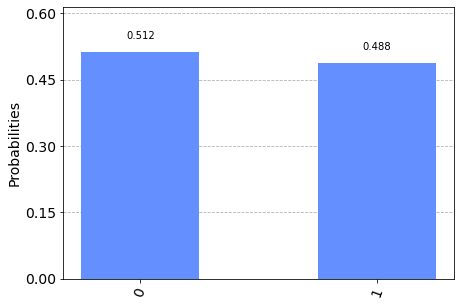

In [7]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

alpha = 0

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)


circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

#circ.draw('mpl') # see circ

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment D: alpha = 0.25


 Fidelity Bob Qubit:   	 69.5%


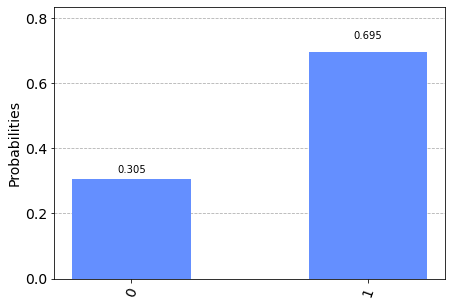

In [8]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

alpha = 0.25

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)


circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

#circ.draw('mpl') # see circ

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)